In [5]:
#importing data and libraries + Cleaning the data
import pandas as pd

df = pd.read_csv('/Users/devanarayanan/Downloads/EW-MAX.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

In [6]:
#defining new variables, namely moving averages. Also defined the independent and dependent variables for the SLRM
df['7MA'] = df['Close'].rolling(window = 7).mean()
df['30MA'] = df['Close'].rolling(window = 30).mean()

df['Next'] = df['Close'].shift(-1)
df.dropna(inplace = True)

x = df[['Adj_Close', '7MA', '30MA']]
y = df['Next']


In [7]:
#checkin for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['variables'] = x.columns

vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]
print(vif)
#conclusion: Multicolinearity porblem present, which is why the model coefficients of the MAs are low.


   variables          VIF
0  Adj_Close  1620.968700
1        7MA  2612.099770
2       30MA   483.867409


In [8]:
#splitting the large dataset into 2: training setand test set(to verify the validity of the model)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [11]:
#defining the actual model
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan


model = LinearRegression()
model.fit(x_train, y_train)

#test for heteroscedasticity
y_train_cap = model.predict(x_train)
residuals = y_train - y_train_cap

x_train_with_const = sm.add_constant(x_train)
bpg_test = het_breuschpagan(residuals, x_train_with_const)

labels = ['Lagrange Multiplier statistic:', 'p-value:', 'f-value:', 'f p-value:']
bpg_results = dict(zip(labels, bpg_test))

if bpg_results['p-value:'] < 0.05:
    print("Conclusion: There is evidence of heteroscedasticity.")
else:
    print("Conclusion: There is no evidence of heteroscedasticity.")
    
#test for autocorrelation
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat:.2f}")

if dw_stat < 1.5:
    print("\nConclusion: There is evidence of strong positive autocorrelation.")
    print("(This is expected in time series data).")
elif dw_stat > 2.5:
    print("\nConclusion: There is evidence of strong negative autocorrelation.")
else:
    print("\nConclusion: There is little to no evidence of first-order autocorrelation.")


y_train_cap = model.predict(x_train)
residuals = y_train - y_train_cap


intercept = model.intercept_
slopes = model.coef_ 

results = pd.DataFrame(slopes, x.columns, columns=['Slopes'])
print(results)




Conclusion: There is evidence of heteroscedasticity.
Durbin-Watson statistic: 2.09

Conclusion: There is little to no evidence of first-order autocorrelation.
             Slopes
Adj_Close  1.016878
7MA       -0.039627
30MA       0.022327


In [ ]:
y_test_cap = model.predict(x_test)
print(y_test_cap[:5])

[35.43407835 36.13212867 36.55425793 35.60481394 35.5632889 ]


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, y_test_cap)
rmse = np.sqrt(mse)

summary_statistics = df['Close'].describe()

print(f"The Root Mean Squared Error (RMSE) of the model is: {rmse:.2f}")
print(f"The closing price standard deviation is: {summary_statistics['std']}")

if summary_statistics['std'] > 10*rmse:
    print("The model is well-fit")
else:
    print("Model is inaccurate")


The Root Mean Squared Error (RMSE) of the model is: 1.59
The closing price standard deviation is: 29.90154907091292
The model is well-fit


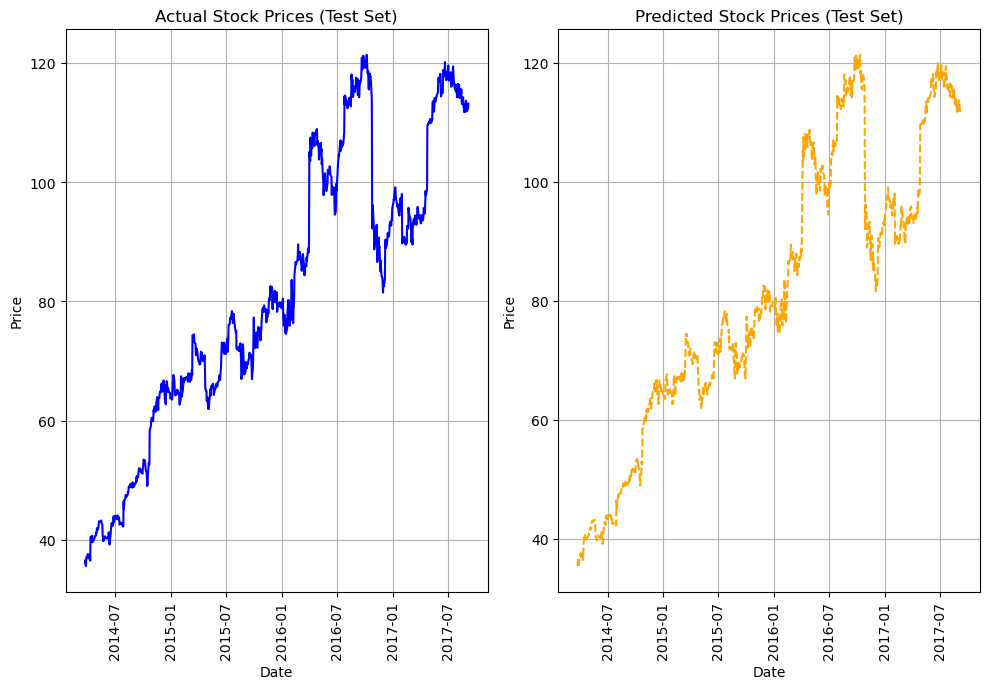

In [ ]:
import matplotlib.pyplot as plt

results_model = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_cap}, index=x_test.index)

fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].plot(results_model['Actual'], color='blue')
ax[0].set_title('Actual Stock Prices (Test Set)')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=90)

ax[1].plot(results_model['Predicted'], color='orange', linestyle='--')
ax[1].set_title('Predicted Stock Prices (Test Set)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price')
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

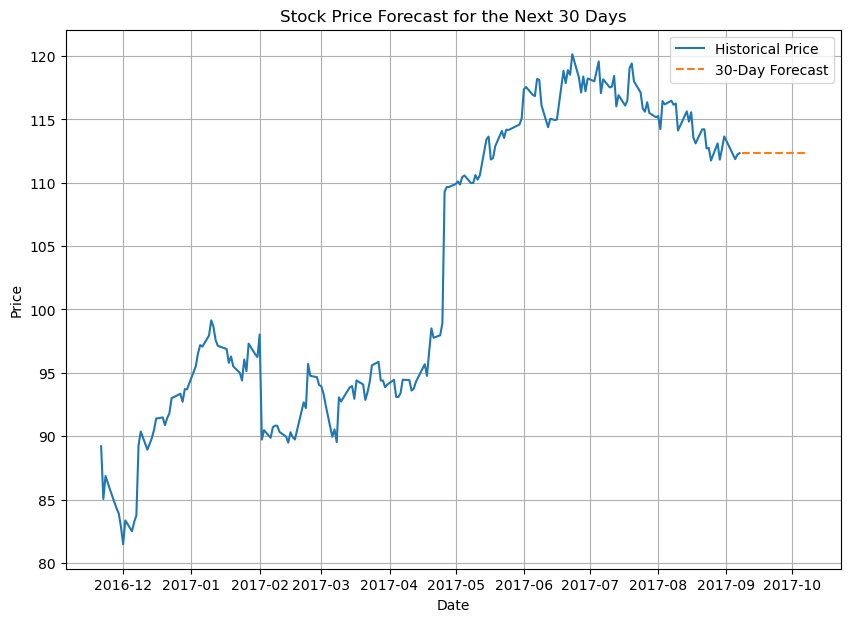

In [ ]:
import numpy as np

df_for_forecast = df.copy()

last_known_row = df_for_forecast.iloc[-1:]
current_variables = last_known_row[['Adj_Close', '7MA', '30MA']]

future_predictions = []

for a in range(30):
    next_day_pred = model.predict(current_variables)[0]
    future_predictions.append(next_day_pred)
    
    last_date = current_variables.index[-1]
    next_date = last_date + pd.Timedelta(days=1)
    
    new_row = pd.DataFrame({
        'Adj_Close': [next_day_pred],
        '7MA': [0],
        '30MA': [0] 
    }, index=[next_date])
    
    df_for_forecast = pd.concat([df_for_forecast, new_row])
    df_for_forecast['7MA'] = df_for_forecast['Adj_Close'].rolling(window=7).mean()
    df_for_forecast['30MA'] = df_for_forecast['Adj_Close'].rolling(window=30).mean()
    
    current_features = df_for_forecast[['Adj_Close', '7MA', '30MA']].iloc[-1:]


forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_df = pd.DataFrame({'Forecast': future_predictions}, index=forecast_index)

plt.figure(figsize=(10, 7))
plt.plot(df.index[-200:], df['Close'][-200:], label='Historical Price')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='30-Day Forecast', linestyle='--')

plt.title('Stock Price Forecast for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
